In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

#Utility functions

In [ ]:
def train_test_split(x, y, s, seed = None):
  N = x.shape[0]
  n = int(N*s)

  inds = np.random.RandomState(seed).permutation(N)

  return x[inds[:n]], y[inds[:n]], x[inds[n:]], y[inds[n:]]

def cross_val_score(model, data, labels, cv, metrics='accuracy', seed = None):
  n = data.shape[0]
  inds = np.random.RandomState(seed).permutation(n)
  map = {'accuracy':0, 'precision':1, 'recall':2, 'f1':3}
 
  acc = []
  for i in range(cv):
    start = i * n//cv
    end = (i+1) * n//cv
    ivalidation = inds[start:end]
    itrain = np.concatenate((inds[:start], inds[end:]), axis=0)

    y_probs = model.fit(data[itrain], labels[itrain]).predict(data[ivalidation])
    y_pred = np.argmax(y_probs,axis=-1)

    scores = evaluate_acc(labels[ivalidation], y_pred)
    acc.append(scores[map[metrics]])
  return acc

def norm(x): #mean-removal+scale to std
  x_std = (x - np.mean(x))/np.std(x)
  
  return x_std

#accuracy = TP+TN/(P+N)
#precision = TP/RP
#recall = TP/P
def evaluate_acc(y_true, y_pred):
  correct = (y_true == y_pred) #TP+TN
  RP = (y_pred == max(y_true)) 

  TP = correct*RP
  P = (y_true == max(y_true))
  
  acc = sum(correct)/len(y_true)
  prec = sum(TP)/sum(RP)
  recall = sum(TP)/sum(P)
  F1 = 2*(prec*recall)/(prec+recall)

  return (acc,prec,recall,F1)

# Get data

In [ ]:
hepfile = "https://raw.githubusercontent.com/zhulanxi/COMP551MiniProject1/main/hepatitis.csv"
diabfile = "https://raw.githubusercontent.com/zhulanxi/COMP551MiniProject1/main/messidor_features.arff"

In [ ]:
#Name of labels/features columns

hepcols = ['Class','AGE','SEX','STEROID','ANTIVIRALS','FATIGUE',
               'MALAISE','ANOREXIA','LIVER_BIG','LIVER FIRM','SPLEEN PALPABLE',
               'SPIDERS','ASCITES','VARICES','BILIRUBIN','ALK_PHOSPHATE',
               'SGOT','ALBUMIN','PROTIME','HISTOLOGY']
#class: 1-DIE 2-LIVE; all other 1/2 columns: 1-no/male 2-yes/female

diabcols = ['Quality','Pre-screening','A1','A2','A3','A4','A5','A6',
            'E1','E2','E3','E4','E5','E6','E7','E8',
            'Distance','Diameter','AM/FM','Class']
#class: 1-contains signs of DR 0-no DR (disease)
#AX, EX: series of test results

### Hepatitis dataset

In [ ]:
hep = pd.read_csv(hepfile,names=hepcols)
hep

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
1,2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
3,2,31,1,?,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1
4,2,34,1,2,2,2,2,2,2,2,2,2,2,2,1.00,?,200,4.0,?,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1,46,1,2,2,1,1,1,2,2,2,1,1,1,7.60,?,242,3.3,50,2
151,2,44,1,2,2,1,2,2,2,1,2,2,2,2,0.90,126,142,4.3,?,2
152,2,61,1,1,2,1,1,2,1,1,2,1,2,2,0.80,75,20,4.1,?,2
153,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.50,81,19,4.1,48,2


In [ ]:
#Checking the distribution of missing data
d = {}
for col in hepcols:
  df = hep[hep.eq('?').any(1)].groupby(col).size().reset_index(name='count')
  d[col] = df[df[col] == '?']['count'].values
  d[col] = d[col] if d[col].size > 0 else [0]
df = pd.DataFrame.from_dict(d).transpose().rename(columns={0:"? count"}).sort_values('? count', ascending=False)
df

,? count
PROTIME,67
ALK_PHOSPHATE,29
ALBUMIN,16
LIVER FIRM,11
LIVER_BIG,10
BILIRUBIN,6
SPLEEN PALPABLE,5
SPIDERS,5
ASCITES,5
VARICES,5


In [ ]:
hep = hep.drop(hep[hep.eq('?').any(1)].index) #drop instances with missing data
hep

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
5,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.90,95,28,4.0,75,1
10,2,39,1,1,1,2,2,2,1,1,2,2,2,2,1.30,78,30,4.4,85,1
11,2,32,1,2,1,1,2,2,2,1,2,1,2,2,1.00,59,249,3.7,54,1
12,2,41,1,2,1,1,2,2,2,1,2,2,2,2,0.90,81,60,3.9,52,1
13,2,30,1,2,2,1,2,2,2,1,2,2,2,2,2.20,57,144,4.9,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2,45,1,2,1,2,2,2,2,2,2,2,2,2,1.30,85,44,4.2,85,2
143,1,49,1,1,2,1,1,2,2,2,1,1,2,2,1.40,85,70,3.5,35,2
145,2,31,1,1,2,1,2,2,2,2,2,2,2,2,1.20,75,173,4.2,54,2
153,2,53,2,1,2,1,2,2,2,2,1,1,2,1,1.50,81,19,4.1,48,2


In [ ]:
#exploring the distribution of features
hep[hep['SEX']==1]

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
5,2,34,1,2,2,2,2,2,2,2,2,2,2,2,0.90,95,28,4.0,75,1
10,2,39,1,1,1,2,2,2,1,1,2,2,2,2,1.30,78,30,4.4,85,1
11,2,32,1,2,1,1,2,2,2,1,2,1,2,2,1.00,59,249,3.7,54,1
12,2,41,1,2,1,1,2,2,2,1,2,2,2,2,0.90,81,60,3.9,52,1
13,2,30,1,2,2,1,2,2,2,1,2,2,2,2,2.20,57,144,4.9,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1,47,1,2,2,1,1,2,2,1,2,1,1,1,1.00,166,30,2.6,31,2
139,2,45,1,2,1,2,2,2,2,2,2,2,2,2,1.30,85,44,4.2,85,2
143,1,49,1,1,2,1,1,2,2,2,1,1,2,2,1.40,85,70,3.5,35,2
145,2,31,1,1,2,1,2,2,2,2,2,2,2,2,1.20,75,173,4.2,54,2


In [ ]:
np.mean(hep)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3370: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Class               1.837500e+00
AGE                 4.066250e+01
SEX                 1.137500e+00
STEROID             2.652764e+77
ANTIVIRALS          1.737500e+00
FATIGUE             2.763889e+77
MALAISE             2.777765e+77
ANOREXIA            2.777765e+77
LIVER_BIG           2.652778e+77
LIVER FIRM          2.638902e+77
SPLEEN PALPABLE     2.777778e+77
SPIDERS             2.765278e+77
ASCITES             2.777765e+77
VARICES             2.777778e+77
ALK_PHOSPHATE      1.197325e+189
SGOT               3.537812e+177
PROTIME            9.481932e+167
HISTOLOGY           1.412500e+00
dtype: float64

In [ ]:
#checking the distribution of binary features
alive_1 = []
alive_2 = []
dead_1 = []
dead_2 = []
tmp = hep.copy()
tmp['Class'] = pd.to_numeric(tmp['Class'])

for feature in hepcols[2:14]+[hepcols[-1]]:
  tmp[feature] = pd.to_numeric(tmp[feature])
  dead_1.append(tmp[(tmp[feature]==1) & (tmp['Class']==1)].shape[0])
  dead_2.append(tmp[(tmp[feature]==2) & (tmp['Class']==1)].shape[0])

  alive_1.append(tmp[(tmp[feature]==1) & (tmp['Class']==2)].shape[0])
  alive_2.append(tmp[(tmp[feature]==2) & (tmp['Class']==2)].shape[0])

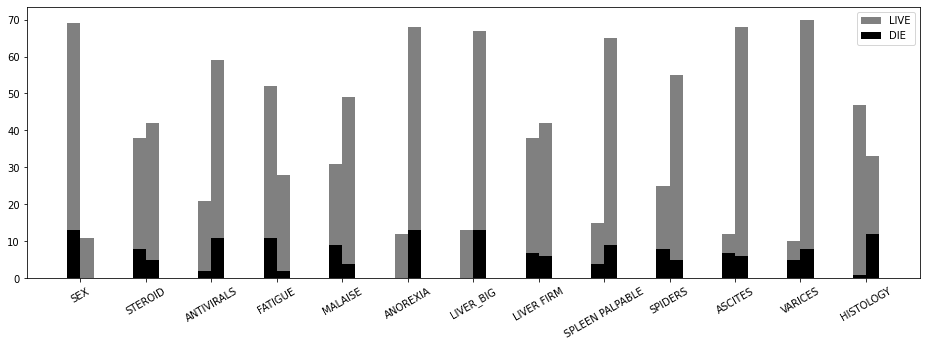

In [ ]:
#plotting the distribution of binary features
ind = np.arange(len(alive_1))

fig, ax = plt.subplots(figsize=(16,5))

bar_list_1 = [ax.bar(ind, alive_1, align='edge',bottom=dead_1, width= -0.2,color='gray',label='LIVE'),
              ax.bar(ind, dead_1, align='edge', width= -0.2,color='black',label='DIE')]
bar_list_2 = [ax.bar(ind, alive_2, align='edge',bottom=dead_2,  width= 0.2,color='gray'),
              ax.bar(ind, dead_2, align='edge', width= 0.2,color='black')]
#left:1-no right:2-yes
#     1-male     2-female
ax.set_xticks(ind)
ax.set_xticklabels(hepcols[2:14]+[hepcols[-1]], rotation = 30)

plt.legend()
plt.show()

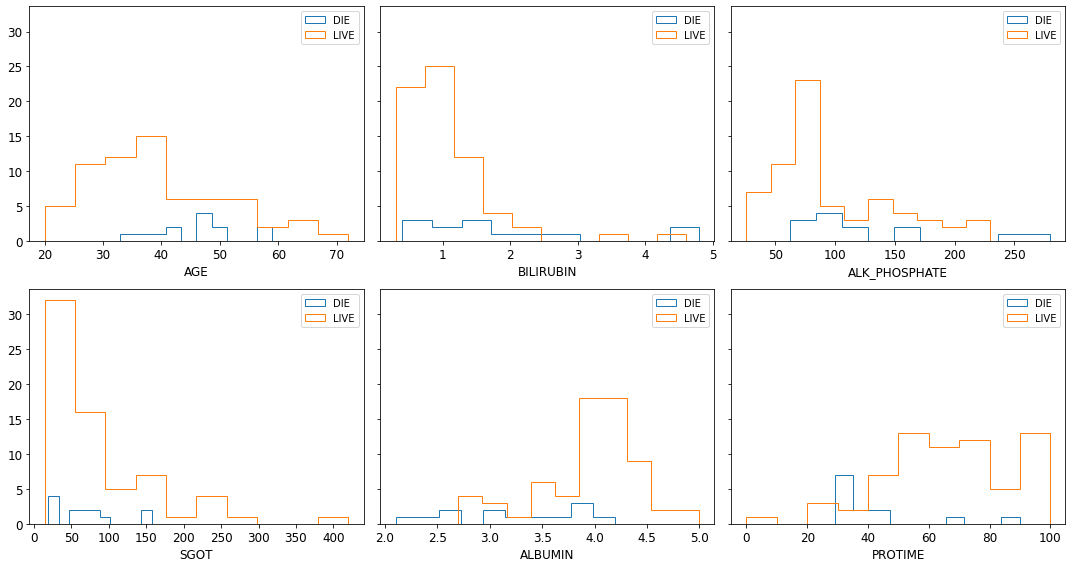

In [ ]:
#Distribution of numerical features
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15,8))

i = 0
j = 0
for feature in ["AGE","BILIRUBIN","ALK_PHOSPHATE","SGOT","ALBUMIN","PROTIME"]:
  axes[i,j].hist(pd.to_numeric(hep[hep['Class']==1][feature]),
                 histtype='step',label='DIE')
  axes[i,j].hist(pd.to_numeric(hep[hep['Class']==2][feature]),
                 histtype='step',label='LIVE')
  axes[i,j].legend()
  axes[i,j].set_xlabel(feature,fontsize=12)
  axes[i,j].tick_params(axis='both', labelsize=12)
  if j == 2:
    i += 1
    j = 0
  else:
    j += 1
    
fig.tight_layout()
plt.show()

In [ ]:
#Adjusting data format (binary features to integer 0/1)
hep = hep.astype(float)
hep[['Class',
  'AGE',
 'SEX',
 'STEROID',
 'ANTIVIRALS',
 'FATIGUE',
 'MALAISE',
 'ANOREXIA',
 'LIVER_BIG',
 'LIVER FIRM',
 'SPLEEN PALPABLE',
 'SPIDERS',
 'ASCITES',
 'VARICES',
 'HISTOLOGY']] = hep[['Class',
  'AGE',
 'SEX',
 'STEROID',
 'ANTIVIRALS',
 'FATIGUE',
 'MALAISE',
 'ANOREXIA',
 'LIVER_BIG',
 'LIVER FIRM',
 'SPLEEN PALPABLE',
 'SPIDERS',
 'ASCITES',
 'VARICES',
 'HISTOLOGY']].astype(int)

hep[['Class',
 'SEX',
 'STEROID',
 'ANTIVIRALS',
 'FATIGUE',
 'MALAISE',
 'ANOREXIA',
 'LIVER_BIG',
 'LIVER FIRM',
 'SPLEEN PALPABLE',
 'SPIDERS',
 'ASCITES',
 'VARICES',
 'HISTOLOGY']] = hep[['Class',
 'SEX',
 'STEROID',
 'ANTIVIRALS',
 'FATIGUE',
 'MALAISE',
 'ANOREXIA',
 'LIVER_BIG',
 'LIVER FIRM',
 'SPLEEN PALPABLE',
 'SPIDERS',
 'ASCITES',
 'VARICES',
 'HISTOLOGY']] - 1

hep

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
5,1,34,0,1,1,1,1,1,1,1,1,1,1,1,0.9,95.0,28.0,4.0,75.0,0
10,1,39,0,0,0,1,1,1,0,0,1,1,1,1,1.3,78.0,30.0,4.4,85.0,0
11,1,32,0,1,0,0,1,1,1,0,1,0,1,1,1.0,59.0,249.0,3.7,54.0,0
12,1,41,0,1,0,0,1,1,1,0,1,1,1,1,0.9,81.0,60.0,3.9,52.0,0
13,1,30,0,1,1,0,1,1,1,0,1,1,1,1,2.2,57.0,144.0,4.9,78.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,45,0,1,0,1,1,1,1,1,1,1,1,1,1.3,85.0,44.0,4.2,85.0,1
143,0,49,0,0,1,0,0,1,1,1,0,0,1,1,1.4,85.0,70.0,3.5,35.0,1
145,1,31,0,0,1,0,1,1,1,1,1,1,1,1,1.2,75.0,173.0,4.2,54.0,1
153,1,53,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0,19.0,4.1,48.0,1


In [ ]:
np.mean(hep)

Class                0.83750
AGE                 40.66250
SEX                  0.13750
STEROID              0.52500
ANTIVIRALS           0.73750
FATIGUE              0.35000
MALAISE              0.61250
ANOREXIA             0.85000
LIVER_BIG            0.83750
LIVER FIRM           0.52500
SPLEEN PALPABLE      0.81250
SPIDERS              0.68750
ASCITES              0.85000
VARICES              0.87500
BILIRUBIN            1.22125
ALK_PHOSPHATE      102.91250
SGOT                82.02500
ALBUMIN              3.84375
PROTIME             62.51250
HISTOLOGY            0.41250
dtype: float64

In [ ]:
hep.corr('spearman')['Class']

Class              1.000000
AGE               -0.255525
SEX                0.175876
STEROID            0.123830
ANTIVIRALS        -0.108776
FATIGUE            0.181151
MALAISE            0.275595
ANOREXIA          -0.185042
LIVER_BIG         -0.194030
LIVER FIRM         0.055978
SPLEEN PALPABLE    0.135643
SPIDERS            0.287839
ASCITES            0.479211
VARICES            0.345785
BILIRUBIN         -0.257384
ALK_PHOSPHATE     -0.188705
SGOT               0.013208
ALBUMIN            0.435175
PROTIME            0.427703
HISTOLOGY         -0.456856
Name: Class, dtype: float64

In [ ]:
# normalize
hep_norm = hep.copy()
for col in hepcols[1:]:
  hep_norm[col] = norm(hep[col])
hep_norm

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
5,1,-0.594372,-0.399275,0.951190,0.596601,1.362770,0.795395,0.420084,0.440488,0.951190,0.480384,0.67420,0.420084,0.377964,-0.369369,-0.148318,-0.759300,0.272841,0.536384,-0.837931
10,1,-0.148314,-0.399275,-1.051315,-1.676163,1.362770,0.795395,0.420084,-2.270208,-1.051315,0.480384,0.67420,0.420084,0.377964,0.090546,-0.466979,-0.731191,0.971312,0.965921,-0.837931
11,1,-0.772795,-0.399275,0.951190,-1.676163,-0.733799,0.795395,0.420084,0.440488,-1.051315,0.480384,-1.48324,0.420084,0.377964,-0.254390,-0.823130,2.346767,-0.251013,-0.365643,-0.837931
12,1,0.030109,-0.399275,0.951190,-1.676163,-0.733799,0.795395,0.420084,0.440488,-1.051315,0.480384,0.67420,0.420084,0.377964,-0.369369,-0.410745,-0.309553,0.098223,-0.451551,-0.837931
13,1,-0.951218,-0.399275,0.951190,0.596601,-0.733799,0.795395,0.420084,0.440488,-1.051315,0.480384,0.67420,0.420084,0.377964,1.125354,-0.860620,0.871034,1.844402,0.665245,-0.837931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,0.386955,-0.399275,0.951190,-1.676163,1.362770,0.795395,0.420084,0.440488,0.951190,0.480384,0.67420,0.420084,0.377964,0.090546,-0.335766,-0.534426,0.622077,0.965921,1.193416
143,0,0.743801,-0.399275,-1.051315,0.596601,-0.733799,-1.257237,0.420084,0.440488,0.951190,-2.081666,-1.48324,0.420084,0.377964,0.205524,-0.335766,-0.169007,-0.600249,-1.181763,1.193416
145,1,-0.862007,-0.399275,-1.051315,0.596601,-0.733799,0.795395,0.420084,0.440488,0.951190,0.480384,0.67420,0.420084,0.377964,-0.024433,-0.523214,1.278618,0.622077,-0.365643,1.193416
153,1,1.100648,2.504541,-1.051315,0.596601,-0.733799,0.795395,0.420084,0.440488,0.951190,-2.081666,-1.48324,0.420084,-2.645751,0.320503,-0.410745,-0.885791,0.447459,-0.623365,1.193416


In [1]:
###Computational intensive cell
#pairplot = sns.pairplot(hep[['AGE', 'BILIRUBIN', 'PROTIME', 'ALBUMIN', 'ALK_PHOSPHATE', 'SGOT','Class']] ,hue="Class")
#pairplot.fig.savefig('pairplot_hep.png')
#plt.show(pairplot)

##Diabetic Retinopathy Debrecen dataset

In [ ]:
diab = pd.read_csv(diabfile,skiprows=24,names=diabcols)
#24 lines of description
diab

,Quality,Pre-screening,A1,A2,A3,A4,A5,A6,E1,E2,E3,E4,E5,E6,E7,E8,Distance,Diameter,AM/FM,Class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1,1,34,34,34,33,31,24,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,1,49,49,49,49,45,37,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1148,1,0,49,48,48,45,43,33,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0,0
1149,1,1,39,36,29,23,13,7,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [ ]:
#Checking the distribution of missing data
#no missing data
d = {}
for col in diabcols:
  df = diab[diab.eq('?').any(1)].groupby(col).size().reset_index(name='count')
  d[col] = df[df[col] == '?']['count'].values
  d[col] = d[col] if d[col].size > 0 else [0]
pd.DataFrame.from_dict(d).transpose().rename(columns={0:"? count"}).sort_values('? count', ascending=False)

,? count
Quality,0
Pre-screening,0
AM/FM,0
Diameter,0
Distance,0
E8,0
E7,0
E6,0
E5,0
E4,0


In [ ]:
#Remove bad quality data ('Quality'=0)
diab = diab[diab['Quality']==1]
diab = diab.drop('Quality', axis=1)

In [ ]:
diab.corr('spearman')['Class']

Pre-screening   -0.075981
A1               0.280544
A2               0.254890
A3               0.226452
A4               0.193564
A5               0.163424
A6               0.129885
E1              -0.026915
E2              -0.057202
E3              -0.009106
E4               0.061502
E5               0.161988
E6               0.194014
E7               0.208103
E8               0.190166
Distance         0.010494
Diameter        -0.030641
AM/FM           -0.039081
Class            1.000000
Name: Class, dtype: float64

In [ ]:
noDR_1

[504, 190]

In [ ]:
DR_1

[549, 194]

In [ ]:
diab[diab['Pre-screening']==1]

,Pre-screening,A1,A2,A3,A4,A5,A6,E1,E2,E3,E4,E5,E6,E7,E8,Distance,Diameter,AM/FM,Class
0,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1,16,16,15,14,12,8,158.177307,84.865487,51.253664,11.283321,1.857293,0.019520,0.006832,0.001952,0.533177,0.104430,1,0
1146,1,34,34,34,33,31,24,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,49,49,49,49,45,37,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1149,1,39,36,29,23,13,7,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [ ]:
#checking the distribution of binary features
DR_1 = []
DR_0 = []
noDR_1 = []
noDR_0 = []
tmp = diab.copy()
tmp['Class'] = pd.to_numeric(tmp['Class'])

for feature in ['Pre-screening','AM/FM']:
  tmp[feature] = pd.to_numeric(tmp[feature])
  DR_1.append(tmp[(tmp[feature]==1) & (tmp['Class']==1)].shape[0])
  DR_0.append(tmp[(tmp[feature]==0) & (tmp['Class']==1)].shape[0])

  noDR_1.append(tmp[(tmp[feature]==1) & (tmp['Class']==0)].shape[0])
  noDR_0.append(tmp[(tmp[feature]==0) & (tmp['Class']==0)].shape[0])

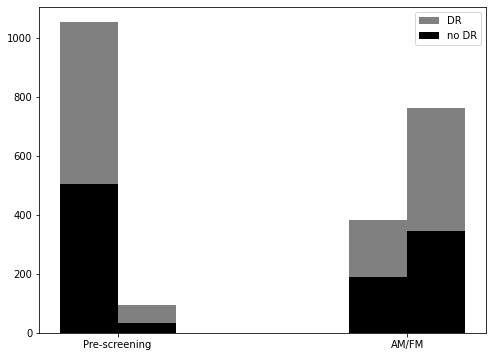

In [ ]:
#plotting the distribution of binary features
ind = np.arange(len(DR_1))

fig, ax = plt.subplots(figsize=(8,6))

bar_list_1 = [ax.bar(ind, DR_1, align='edge',bottom=noDR_1, width= -0.2,color='gray',label='DR'),
              ax.bar(ind, noDR_1, align='edge', width= -0.2,color='black',label='no DR')]
bar_list_2 = [ax.bar(ind, DR_0, align='edge',bottom=noDR_0,  width= 0.2,color='gray'),
              ax.bar(ind, noDR_0, align='edge', width= 0.2,color='black')]

#left: 1, right: 0
ax.set_xticks(ind)
ax.set_xticklabels(['Pre-screening','AM/FM'])

plt.legend()
plt.show()

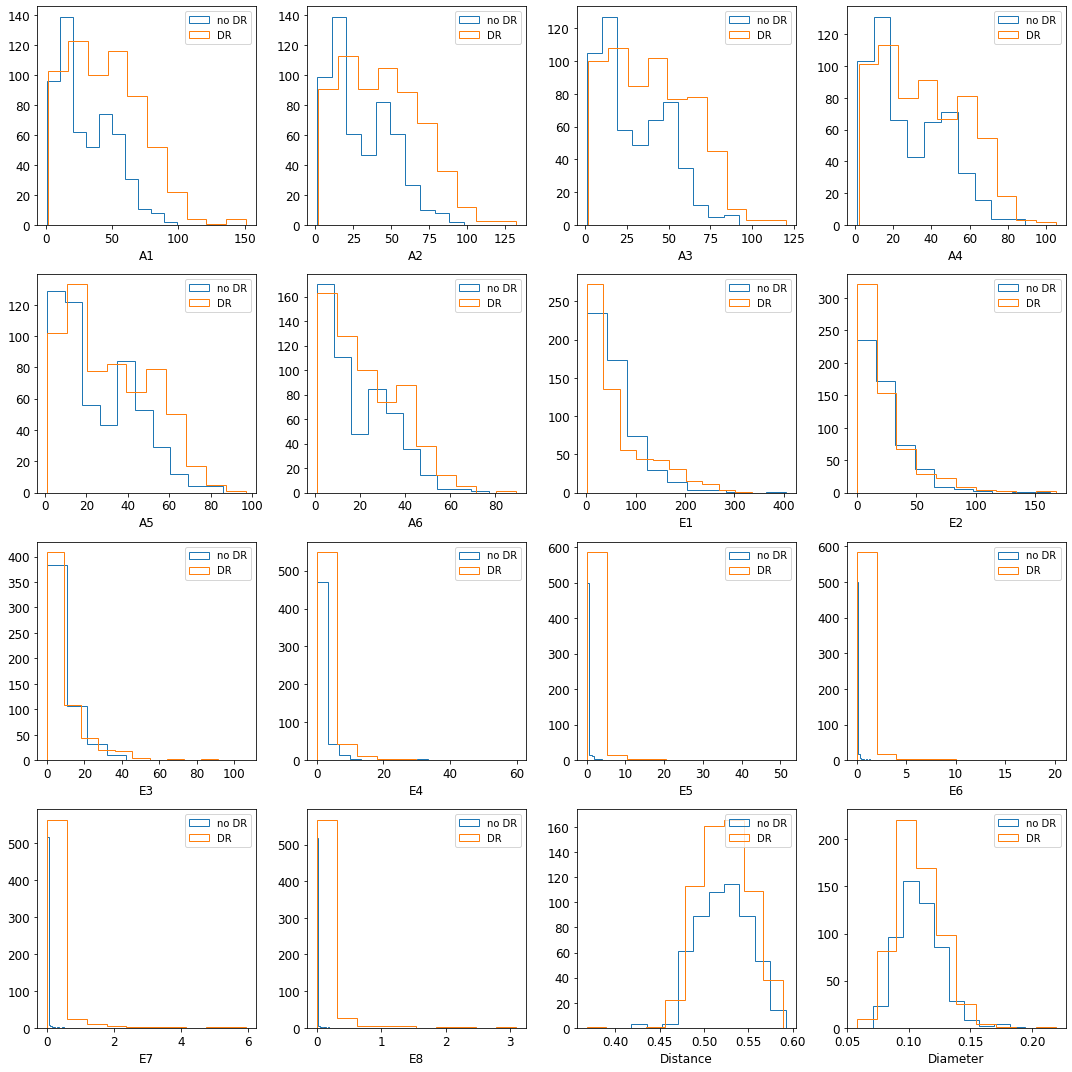

In [ ]:
#Distribution of numerical features
fig, axes = plt.subplots(4, 4, figsize=(15,15))

i = 0
j = 0
for feature in diabcols[2:-2]:
  axes[i,j].hist(pd.to_numeric(diab[diab['Class']==0][feature]),
                 histtype='step',label='no DR')
  axes[i,j].hist(pd.to_numeric(diab[diab['Class']==1][feature]),
                 histtype='step',label='DR')
  axes[i,j].legend()
  axes[i,j].set_xlabel(feature,fontsize=12)
  axes[i,j].tick_params(axis='both', labelsize=12)
  if j == 3:
    i += 1
    j = 0
  else:
    j += 1
    
fig.tight_layout()
plt.show()

In [ ]:
diab_norm = diab.copy()
for col in diabcols[1:-1]:
  diab_norm[col] = norm(diab[col])
diab_norm

,Pre-screening,A1,A2,A3,A4,A5,A6,E1,E2,E3,E4,E5,E6,E7,E8,Distance,Diameter,AM/FM,Class
0,0.298779,-0.642986,-0.620352,-0.577884,-0.631667,-0.552731,-0.475225,-0.246744,-0.249790,-0.299366,-0.272772,-0.218750,-0.194784,-0.205533,-0.186584,-1.293600,-0.467232,1.409602,0
1,0.298779,-0.564964,-0.537422,-0.577884,-0.679009,-0.655210,-0.541416,-0.113038,0.029256,-0.467498,-0.409669,-0.224672,-0.197582,-0.205583,-0.186695,-0.080880,2.021070,-0.709420,0
2,0.298779,0.917458,0.955328,1.043699,1.025303,0.933206,0.782405,-0.145180,0.223529,0.341581,0.766362,0.334198,0.151376,-0.110609,-0.165259,0.275607,1.131674,-0.709420,1
3,0.298779,0.644380,0.665071,0.780739,0.835935,0.728249,0.650023,-0.408072,-0.218756,0.033180,0.314892,0.111601,0.056124,-0.196189,-0.199934,-1.422665,0.360446,-0.709420,0
4,0.298779,0.215258,0.291884,0.386300,0.409857,0.523292,0.385259,-0.792051,-0.676200,-0.719419,-0.469306,-0.226242,-0.201269,-0.215360,-0.208478,-1.684752,0.852736,-0.709420,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,0.298779,-0.174853,-0.122769,-0.051965,0.031121,0.113379,0.186685,-0.996600,-1.029789,-0.752193,-0.468513,-0.226242,-0.201269,-0.215360,-0.208478,0.509770,0.472839,-0.709420,0
1147,0.298779,0.410314,0.499210,0.605433,0.788593,0.830728,1.047169,-0.019148,0.194982,-0.057666,-0.219857,-0.225618,-0.201269,-0.215360,-0.208478,-0.229773,0.887379,-0.709420,0
1148,-3.346958,0.410314,0.457745,0.561606,0.599225,0.728249,0.782405,-0.579269,-0.426232,-0.602498,-0.434200,-0.221730,-0.201269,-0.215360,-0.208478,1.335796,1.204268,-0.709420,0
1149,0.298779,0.020203,-0.039838,-0.271098,-0.442299,-0.808928,-0.938563,-0.407071,-0.489325,-0.345169,-0.194895,0.000331,0.107546,0.384751,0.765876,-1.326802,-0.093614,1.409602,1


In [ ]:
diab[diab['Class']==0]

,Pre-screening,A1,A2,A3,A4,A5,A6,E1,E2,E3,E4,E5,E6,E7,E8,Distance,Diameter,AM/FM,Class
0,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
3,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
7,1,6,6,6,6,2,1,20.679649,9.497786,1.223660,0.150382,0.000000,0.000000,0.000000,0.000000,0.576318,0.071071,1,0
10,1,45,45,45,43,40,32,84.358401,50.977459,17.293722,1.974419,0.000000,0.000000,0.000000,0.000000,0.546008,0.112378,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1,16,16,15,14,12,8,158.177307,84.865487,51.253664,11.283321,1.857293,0.019520,0.006832,0.001952,0.533177,0.104430,1,0
1146,1,34,34,34,33,31,24,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,49,49,49,49,45,37,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1148,0,49,48,48,45,43,33,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0,0


In [ ]:
###Computational intensive cell
#pairplot = sns.pairplot(diab[diabcols[2:-2] + ['Class']] ,hue="Class")
#pairplot.fig.savefig('pairplot_diab.png')
#plt.show(pairplot)

# Split data

In [ ]:
seed = 1234

x_hep, y_hep = hep.iloc[:,1:].to_numpy(dtype=float), hep['Class'].to_numpy()

split = .9

#print the feature shape and classes of dataset 
(N,D), C = x_hep.shape, np.max(y_hep)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

#split the dataset into train and test
x_train_hep, y_train_hep, x_test_hep, y_test_hep = train_test_split(x_hep, y_hep, split, seed)

print(f'train: {x_train_hep.shape}, test: {x_test_hep.shape}')

instances (N) 	 80 
 features (D) 	 19 
 classes (C) 	 2
train: (72, 19), test: (8, 19)


In [ ]:
#normalized features
x_hep_norm, y_hep_norm = hep_norm.iloc[:,1:].to_numpy(dtype=float), hep_norm['Class'].to_numpy()

#print the feature shape and classes of dataset 
(N,D), C = x_hep_norm.shape, np.max(y_hep_norm)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

#split the dataset into train and test
x_train_hep_norm, y_train_hep_norm, x_test_hep_norm, y_test_hep_norm = train_test_split(x_hep_norm, y_hep_norm, split, seed)

print(f'train: {x_train_hep_norm.shape}, test: {x_test_hep_norm.shape}')

instances (N) 	 80 
 features (D) 	 19 
 classes (C) 	 2
train: (72, 19), test: (8, 19)


In [ ]:
x_diab, y_diab = diab.iloc[:,:-1].to_numpy(dtype=float), diab['Class'].to_numpy()
split = .9

#print the feature shape and classes of dataset 
(N,D), C = x_diab.shape, np.max(y_diab)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

#split the dataset into train and test
x_train_diab, y_train_diab, x_test_diab, y_test_diab = train_test_split(x_diab, y_diab, split, seed)

print(f'train: {x_train_diab.shape}, test: {x_test_diab.shape}')

instances (N) 	 1147 
 features (D) 	 18 
 classes (C) 	 2
train: (1032, 18), test: (115, 18)


In [ ]:
x_diab_norm, y_diab_norm = diab_norm.iloc[:,:-1].to_numpy(dtype=float), diab_norm['Class'].to_numpy()

#print the feature shape and classes of dataset 
(N,D), C = x_diab_norm.shape, np.max(y_diab_norm)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

#split the dataset into train and test
x_train_diab_norm, y_train_diab_norm, x_test_diab_norm, y_test_diab_norm = train_test_split(x_diab_norm, y_diab_norm, split, seed)

print(f'train: {x_train_diab_norm.shape}, test: {x_test_diab_norm.shape}')

instances (N) 	 1147 
 features (D) 	 18 
 classes (C) 	 2
train: (1032, 18), test: (115, 18)


# Models

##KNN

In [ ]:
def euclidean(x, y):
    return ( np.sqrt(np.sum((x - y)**2, axis=-1)) )

def manhattan(x, y):
    return ( np.sum(np.abs(x - y), axis=-1) )

dist_fcts = [euclidean, manhattan]

In [ ]:
#reference: provided code example
class KNN():
  def __init__(self, k = 1, dist_fn = euclidean):
    self.k = k
    self.dist_fn = dist_fn

  def fit(self, x, y, k = None, dist_fn = None):
    self.x = x
    self.y = y
    if k:
      self.k = k
    self.C = np.max(y) + 1
    if dist_fn:
      self.dist_fn = dist_fn
    return self

  def predict(self, x_test):
    num_test = x_test.shape[0]
    #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
    distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
    #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
    knns = np.zeros((num_test, self.k), dtype=int)
    #ith-row of y_prob has the probability distribution over C classes
    y_prob = np.zeros((num_test, self.C))
    for i in range(num_test):
        knns[i,:] = np.argsort(distances[i])[:self.k]
        y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
    #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
    #simply divide by K to get a probability distribution
    y_prob /= self.k
    return y_prob

## Decision Tree

In [ ]:
#from given example
class Node:
  def __init__(self, data_indices, parent):
      self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
      self.left = None                                    #stores the left child of the node 
      self.right = None                                   #stores the right child of the node
      self.split_feature = None                           #the feature for split at this node
      self.split_value = None                             #the value of the feature for split at this node

      if parent:
          self.depth = parent.depth + 1                   #obtain the depth of the node by adding one to depth of the parent 
          self.num_classes = parent.num_classes           #copies the num classes from the parent 
          self.data = parent.data                         #copies the data from the parent
          self.labels = parent.labels                     #copies the labels from the parent
          class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) 
          #this is counting frequency of different labels in the region defined by this node
          self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
          #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

In [ ]:
#from given example
def greedy_test(node, cost_fn):
  #initialize the best parameter values
  best_cost = np.inf
  best_feature, best_value = None, None
  num_instances, num_features = node.data.shape

  #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
  data_sorted = np.sort(node.data[node.data_indices],axis=0)
  test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.

  for f in range(num_features):
      #stores the data corresponding to the f-th feature
      data_f = node.data[node.data_indices, f]

      for test in test_candidates[:,f]:
          #Split the indices using the test value of f-th feature
          left_indices = node.data_indices[data_f <= test]
          right_indices = node.data_indices[data_f > test]

          #we can't have a split where a child has zero element
          #if this is true over all the test features and their test values  then the function returns the best cost as infinity
          if len(left_indices) == 0 or len(right_indices) == 0:                
              continue

          #compute the left and right cost based on the current split                                                         
          left_cost = cost_fn(node.labels[left_indices])
          right_cost = cost_fn(node.labels[right_indices])

          num_left, num_right = left_indices.shape[0], right_indices.shape[0]
          #get the combined cost using the weighted sum of left and right cost
          cost = (num_left * left_cost + num_right * right_cost)/num_instances

          #update only when a lower cost is encountered
          if cost < best_cost:
              best_cost = cost
              best_feature = f
              best_value = test

          #ADDED
          #for binary features the first test (<= 1 or >1) should be enough 
          if len(set(data_f)) <= 2:
              break
  return best_cost, best_feature, best_value

In [ ]:
#reference: provided code example
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [ ]:
#reference: provided code example
class DT():
  def __init__(self, num_classes=None, min_leaf_instances=1, max_depth=3, cost_fn=cost_misclassification) -> None:
    self.max_depth = max_depth      #maximum dept for termination 
    self.cost_fn = cost_fn          #stores the cost function of the decision tree 
    self.root = None                #stores the root of the decision tree 
    self.num_classes = num_classes  #stores the total number of classes
    self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
  
  def fit(self, x, y, max_depth=None, cost_fn=None):
    if max_depth:
      self.max_depth = max_depth      #maximum dept for termination
    if cost_fn:
      self.cost_fn = cost_fn          #stores the cost function of the decision tree 
    self.data = x
    self.labels = y
    if self.num_classes is None:
        self.num_classes = np.max(y) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(x.shape[0]), None)
    self.root.data = x
    self.root.labels = y
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

  def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

  def predict(self, x):
    class_probs = np.zeros((x.shape[0], self.num_classes))
    for n, x in enumerate(x):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

# Training

## KNN

In [ ]:
knn = KNN()

y_probs_hep = knn.fit(x_train_hep, y_train_hep).predict(x_test_hep)
y_pred_hep = np.argmax(y_probs_hep,axis=-1)

acc_hep = evaluate_acc(y_test_hep, y_pred_hep)
acc_hep

(1.0, 1.0, 1.0, 1.0)

In [ ]:
print(y_probs_hep)
y_pred_hep

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


array([1, 1, 1, 1, 0, 1, 1, 1])

euclidean original best k: 9
euclidean original validation accuracy: 0.8339285714285714
euclidean normalized best k: 9
euclidean normalized validation accuracy: 0.9178571428571429
manhattan original best k: 9
manhattan original validation accuracy: 0.8339285714285714
manhattan normalized best k: 7
manhattan normalized validation accuracy: 0.9035714285714287


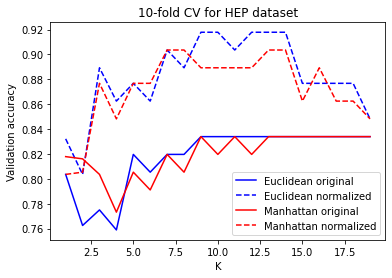

In [ ]:
# 10 fold cv
mean = []
ks = list(range(1, 20))
for k in ks:
  scr = cross_val_score(KNN(k), x_train_hep, y_train_hep, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(ks, mean, 'b', label='Euclidean original')

print(f'euclidean original best k: {ks[np.argmax(mean)]}')
print(f'euclidean original validation accuracy: {np.max(mean)}')

mean = []
for k in ks:
  scr = cross_val_score(KNN(k), x_train_hep_norm, y_train_hep_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(ks, mean, 'b--', label='Euclidean normalized')

print(f'euclidean normalized best k: {ks[np.argmax(mean)]}')
print(f'euclidean normalized validation accuracy: {np.max(mean)}')

mean = []
for k in ks:
  scr = cross_val_score(KNN(k, manhattan), x_train_hep, y_train_hep, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(ks, mean, 'r', label='Manhattan original')

print(f'manhattan original best k: {ks[np.argmax(mean)]}')
print(f'manhattan original validation accuracy: {np.max(mean)}')

mean = []
for k in ks:
  scr = cross_val_score(KNN(k, manhattan), x_train_hep_norm, y_train_hep_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(ks, mean, 'r--', label='Manhattan normalized')

print(f'manhattan normalized best k: {ks[np.argmax(mean)]}')
print(f'manhattan normalized validation accuracy: {np.max(mean)}')

plt.title('10-fold CV for HEP dataset')
plt.xlabel('K')
plt.ylabel('Validation accuracy')
plt.legend()
plt.savefig('10foldHEP.jpg',bbox_layout='tight')
plt.show()

euclidean original best k: 15
euclidean original validation accuracy: 0.682178864824496
euclidean normalized best k: 18
euclidean normalized validation accuracy: 0.6531740104555638
manhattan original best k: 13
manhattan original validation accuracy: 0.6831777445855115
manhattan normalized best k: 15
manhattan normalized validation accuracy: 0.6638256161314413


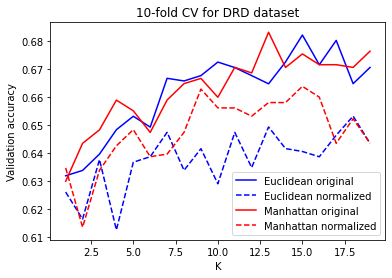

In [ ]:
# 10 fold cv
mean = []
ks = list(range(1, 20))
for k in ks:
  scr = cross_val_score(KNN(k), x_train_diab, y_train_diab, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(ks, mean, 'b', label='Euclidean original')

print(f'euclidean original best k: {ks[np.argmax(mean)]}')
print(f'euclidean original validation accuracy: {np.max(mean)}')

mean = []
for k in ks:
  scr = cross_val_score(KNN(k), x_train_diab_norm, y_train_diab_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(ks, mean, 'b--', label='Euclidean normalized')

print(f'euclidean normalized best k: {ks[np.argmax(mean)]}')
print(f'euclidean normalized validation accuracy: {np.max(mean)}')

mean = []
for k in ks:
  scr = cross_val_score(KNN(k, manhattan), x_train_diab, y_train_diab, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(ks, mean, 'r', label='Manhattan original')

print(f'manhattan original best k: {ks[np.argmax(mean)]}')
print(f'manhattan original validation accuracy: {np.max(mean)}')

mean = []
for k in ks:
  scr = cross_val_score(KNN(k, manhattan), x_train_diab_norm, y_train_diab_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(ks, mean, 'r--', label='Manhattan normalized')

print(f'manhattan normalized best k: {ks[np.argmax(mean)]}')
print(f'manhattan normalized validation accuracy: {np.max(mean)}')

plt.title('10-fold CV for DRD dataset')
plt.xlabel('K')
plt.ylabel('Validation accuracy')
plt.legend()
plt.savefig('10foldDRD.jpg',bbox_layout='tight')
plt.show()

In [ ]:
y_probs_diab = knn.fit(x_train_diab, y_train_diab, k=3, dist_fn=manhattan).predict(x_test_diab)
y_pred_diab = np.argmax(y_probs_diab,axis=-1)

evaluate_acc(y_test_diab, y_pred_diab)

(0.5826086956521739, 0.6538461538461539, 0.53125, 0.5862068965517242)

In [ ]:
knn = KNN()

ks = range(1,20)
accs_eu = []
accs_man = []
accs_eu_norm = []
accs_man_norm = []

for k in ks:
  tmp1 = knn.fit(x_train_hep, y_train_hep, k, dist_fn=euclidean).predict(x_test_hep)
  tmp2 = knn.fit(x_train_hep, y_train_hep, k, dist_fn=manhattan).predict(x_test_hep)
  tmp3 = np.argmax(tmp1,axis=-1)
  tmp4 = np.argmax(tmp2,axis=-1)


  accs_eu.append(evaluate_acc(y_test_hep, tmp3)[0])
  accs_man.append(evaluate_acc(y_test_hep, tmp4)[0])

  
  tmp1 = knn.fit(x_train_hep_norm, y_train_hep_norm, k, dist_fn=euclidean).predict(x_test_hep_norm)
  tmp2 = knn.fit(x_train_hep_norm, y_train_hep_norm, k, dist_fn=manhattan).predict(x_test_hep_norm)
  tmp3 = np.argmax(tmp1,axis=-1)
  tmp4 = np.argmax(tmp2,axis=-1)


  accs_eu_norm.append(evaluate_acc(y_test_hep_norm, tmp3)[0])
  accs_man_norm.append(evaluate_acc(y_test_hep_norm, tmp4)[0])

euclidean, accuracy= 1.0
euclidean k=9 accuracy= 0.875
manhattan, accuracy= 0.875
euclidean normalized  k=9 accuracy= 0.75
manhattan normalized, accuracy= 0.875


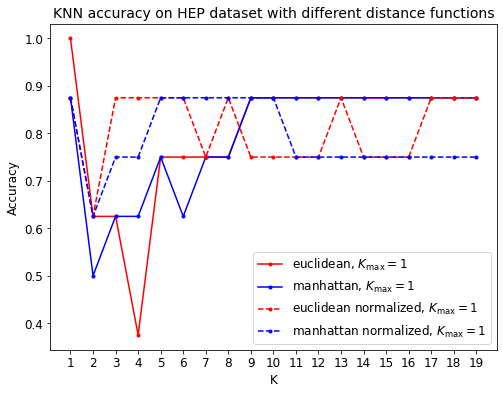

In [ ]:
print('euclidean, accuracy= '+str(max(accs_eu)))
print('manhattan, accuracy= '+str(max(accs_man)))
print('euclidean normalized  k=9 accuracy= '+str((accs_eu_norm[8])))
print('manhattan normalized, accuracy= '+str(max(accs_man_norm)))

from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize=(8,6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticks(range(1,20))

# ax.plot(ks,accs_eu,'.-',label='Euclidean')
# ax.plot(ks,accs_man,'.-',label='Manhattan')
ax.plot(ks,accs_eu,'r.-',label='euclidean, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_eu)]))
ax.plot(ks,accs_man,'b.-',label='manhattan, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_man)]))

ax.plot(ks,accs_eu_norm,'r.--',label='euclidean normalized, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_eu_norm)]))
ax.plot(ks,accs_man_norm,'b.--',label='manhattan normalized, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_man_norm)]))

# ax.vlines(ks[np.argmax(accs_eu)],ymin=min(accs_eu), ymax=max(accs_eu),
#           linestyles='--',color='r')
# ax.vlines(ks[np.argmax(accs_man)],ymin=min(accs_eu), ymax=max(accs_man),
#           linestyles='--',color='b')

# ax.vlines(ks[np.argmax(accs_eu_norm)],ymin=min(accs_eu_norm), ymax=max(accs_eu_norm),
#           linestyles='--',color='#1f77b4')
# ax.vlines(ks[np.argmax(accs_man_norm)],ymin=min(accs_eu_norm), ymax=max(accs_man_norm),
#           linestyles='--',color='#ff7f0e')

plt.xlabel('K',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('KNN accuracy on HEP dataset with different distance functions',fontsize=14)
plt.legend(fontsize=12)
plt.savefig('testaccHEP.jpg',bbox_layout='tight')
plt.show()

In [ ]:
knn = KNN()

ks = range(1,20)
accs_eu = []
accs_man = []
accs_eu_norm = []
accs_man_norm = []

for k in ks:
  tmp1 = knn.fit(x_train_diab, y_train_diab, k, dist_fn=euclidean).predict(x_test_diab)
  tmp2 = knn.fit(x_train_diab, y_train_diab, k, dist_fn=manhattan).predict(x_test_diab)
  tmp3 = np.argmax(tmp1,axis=-1)
  tmp4 = np.argmax(tmp2,axis=-1)


  accs_eu.append(evaluate_acc(y_test_diab, tmp3)[0])
  accs_man.append(evaluate_acc(y_test_diab, tmp4)[0])

  
  tmp1 = knn.fit(x_train_diab_norm, y_train_diab_norm, k, dist_fn=euclidean).predict(x_test_diab_norm)
  tmp2 = knn.fit(x_train_diab_norm, y_train_diab_norm, k, dist_fn=manhattan).predict(x_test_diab_norm)
  tmp3 = np.argmax(tmp1,axis=-1)
  tmp4 = np.argmax(tmp2,axis=-1)


  accs_eu_norm.append(evaluate_acc(y_test_diab_norm, tmp3)[0])
  accs_man_norm.append(evaluate_acc(y_test_diab_norm, tmp4)[0])

euclidean, accuracy= 0.6260869565217392
manhattan, accuracy= 0.6260869565217392
manhattan k=13 accuracy= 0.6173913043478261
euclidean normalized, accuracy= 0.591304347826087
manhattan normalized, accuracy= 0.6173913043478261


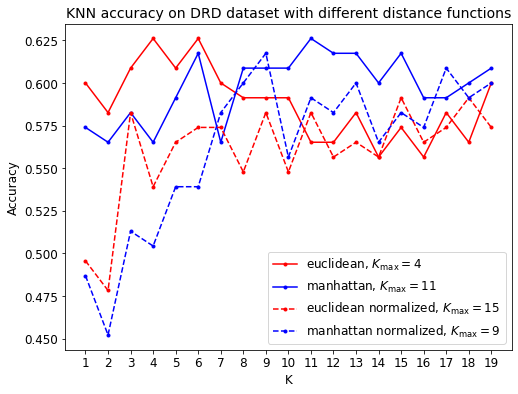

In [ ]:
print('euclidean, accuracy= '+str(max(accs_eu)))
print('manhattan, accuracy= '+str(max(accs_man)))
print('manhattan k=13 accuracy= '+str((accs_man[12])))
print('euclidean normalized, accuracy= '+str(max(accs_eu_norm)))
print('manhattan normalized, accuracy= '+str(max(accs_man_norm)))

ax = plt.figure(figsize=(8,6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticks(range(1,20))

# ax.plot(ks,accs_eu,'.-',label='Euclidean')
# ax.plot(ks,accs_man,'.-',label='Manhattan')
ax.plot(ks,accs_eu,'r.-',label='euclidean, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_eu)]))
ax.plot(ks,accs_man,'b.-',label='manhattan, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_man)]))

ax.plot(ks,accs_eu_norm,'r.--',label='euclidean normalized, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_eu_norm)]))
ax.plot(ks,accs_man_norm,'b.--',label='manhattan normalized, $K_\mathrm{max}=$'+str(ks[np.argmax(accs_man_norm)]))

# ax.vlines(ks[np.argmax(accs_eu)],ymin=min(accs_eu), ymax=max(accs_eu),
#           linestyles='--',color='r')
# ax.vlines(ks[np.argmax(accs_man)],ymin=min(accs_eu), ymax=max(accs_man),
#           linestyles='--',color='b')

# ax.vlines(ks[np.argmax(accs_eu_norm)],ymin=min(accs_eu_norm), ymax=max(accs_eu_norm),
#           linestyles='--',color='#1f77b4')
# ax.vlines(ks[np.argmax(accs_man_norm)],ymin=min(accs_eu_norm), ymax=max(accs_man_norm),
#           linestyles='--',color='#ff7f0e')

plt.xlabel('K',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('KNN accuracy on DRD dataset with different distance functions',fontsize=14)
plt.legend(fontsize=12)
plt.savefig('testaccDRD.jpg',bbox_layout='tight')
plt.show()

### Decision Boundary

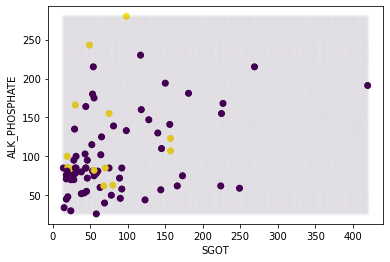

In [ ]:
#features
f1 = 14
f1name = 'ALK_PHOSPHATE'
f2 = 15
f2name = 'SGOT'

x0v = np.linspace(np.min(x_hep[:,f1]), np.max(x_hep[:,f1]), 200)
x1v = np.linspace(np.min(x_hep[:,f2]), np.max(x_hep[:,f2]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN()

y_train_prob = np.zeros((y_hep.shape[0], 2))
y_train_prob[np.arange(y_hep.shape[0]), y_hep] = 1

y_prob_all = model.fit(x_hep[:,[f2,f1]], y_hep,k=7, dist_fn=manhattan).predict(x_all)

y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_hep[:,f2], x_hep[:,f1], c=y_train_prob[:,0], marker='o', alpha=1)
plt.scatter(x_all[:,1], x_all[:,0], c=y_pred_all[:,0], marker='.', alpha=0.01)

plt.xlabel(f2name)
plt.ylabel(f1name)
plt.savefig('KNNBoundHEP.png')
plt.show()

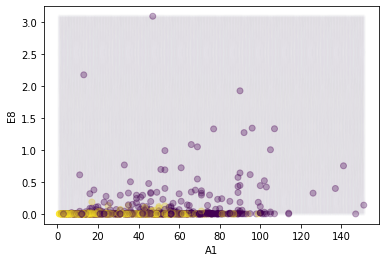

In [ ]:
f1 = -4
f1name = 'E8'
f2 = 1
f2name = 'A1'

x0v = np.linspace(np.min(x_diab[:,f1]), np.max(x_diab[:,f1]), 200)
x1v = np.linspace(np.min(x_diab[:,f2]), np.max(x_diab[:,f2]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN()

y_train_prob = np.zeros((y_diab.shape[0], 2))
y_train_prob[np.arange(y_diab.shape[0]), y_diab] = 1

y_prob_all = model.fit(x_diab[:,[f2,f1]], y_diab,k=13,dist_fn=manhattan).predict(x_all)

y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_diab[:,f2], x_diab[:,f1], c=y_train_prob[:,0], marker='o', alpha=.3)
plt.scatter(x_all[:,1], x_all[:,0], c=y_pred_all[:,0], marker='.', alpha=0.01)

plt.xlabel(f2name)
plt.ylabel(f1name)
plt.savefig('KNNBoundDRD.png')
plt.show()

## Decision tree

In [ ]:
dt = DT()

In [ ]:

y_probs_hep = dt.fit(x_train_hep, y_train_hep, max_depth=1).predict(x_test_hep)
y_pred_hep = np.argmax(y_probs_hep,axis=-1)

acc_hep = evaluate_acc(y_test_hep, y_pred_hep)
acc_hep

(0.75, 1.0, 0.7142857142857143, 0.8333333333333333)

missclassification original best depth: 4
missclassification original validation accuracy: 0.8625
missclassification normalized best depth: 4
missclassification normalized validation accuracy: 0.8625
entropy original best depth: 3
entropy original validation accuracy: 0.8357142857142857
entropy normalized best depth: 3
entropy normalized validation accuracy: 0.8357142857142857
gini original best depth: 3
gini original validation accuracy: 0.8071428571428572
gini normalized best depth: 3
gini normalized validation accuracy: 0.8071428571428572


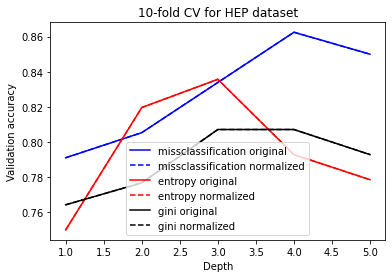

In [ ]:
# 10 fold cv
mean = []
depths = list(range(1, 6))
for k in depths:
  scr = cross_val_score(DT(max_depth=k), x_train_hep, y_train_hep, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(depths, mean, 'b', label='missclassification original')

print(f'missclassification original best depth: {depths[np.argmax(mean)]}')
print(f'missclassification original validation accuracy: {np.max(mean)}')

mean = []
for k in depths:
  scr = cross_val_score(DT(max_depth=k), x_train_hep_norm, y_train_hep_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(depths, mean, 'b--', label='missclassification normalized')

print(f'missclassification normalized best depth: {depths[np.argmax(mean)]}')
print(f'missclassification normalized validation accuracy: {np.max(mean)}')

mean = []
for k in depths:
  scr = cross_val_score(DT(max_depth=k, cost_fn=cost_entropy), x_train_hep, y_train_hep, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(depths, mean, 'r', label='entropy original')

print(f'entropy original best depth: {depths[np.argmax(mean)]}')
print(f'entropy original validation accuracy: {np.max(mean)}')

mean = []
for k in depths:
  scr = cross_val_score(DT(max_depth=k, cost_fn=cost_entropy), x_train_hep_norm, y_train_hep_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(depths, mean, 'r--', label='entropy normalized')

print(f'entropy normalized best depth: {depths[np.argmax(mean)]}')
print(f'entropy normalized validation accuracy: {np.max(mean)}')


mean = []
for k in depths:
  scr = cross_val_score(DT(max_depth=k, cost_fn=cost_gini_index), x_train_hep_norm, y_train_hep_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(depths, mean, 'k', label='gini original')

print(f'gini original best depth: {depths[np.argmax(mean)]}')
print(f'gini original validation accuracy: {np.max(mean)}')

mean = []
for k in depths:
  scr = cross_val_score(DT(max_depth=k, cost_fn=cost_gini_index), x_train_hep_norm, y_train_hep_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(depths, mean, 'k--', label='gini normalized')

print(f'gini normalized best depth: {depths[np.argmax(mean)]}')
print(f'gini normalized validation accuracy: {np.max(mean)}')

plt.title('10-fold CV for HEP dataset')
plt.xlabel('Depth')
plt.ylabel('Validation accuracy')
plt.legend()
plt.savefig('DT10foldHEP.png')
plt.show()

In [ ]:
y_probs_hep = dt.fit(x_train_hep, y_train_hep, max_depth=1).predict(x_train_hep)
y_pred_hep = np.argmax(y_probs_hep,axis=-1)

acc_hep = evaluate_acc(y_train_hep, y_pred_hep)
acc_hep

(0.8888888888888888,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333)

In [ ]:
depths = range(1,6)
accs_mis = []
accs_entropy = []
accs_gini = []

for depth in depths:
  tmp1 = dt.fit(x_train_hep, y_train_hep, depth, cost_fn=cost_misclassification).predict(x_test_hep)
  tmp2 = dt.fit(x_train_hep, y_train_hep, depth, cost_fn=cost_entropy).predict(x_test_hep)
  tmp3 = dt.fit(x_train_hep, y_train_hep, depth, cost_fn=cost_gini_index).predict(x_test_hep)

  tmp4 = np.argmax(tmp1,axis=-1)
  tmp5 = np.argmax(tmp2,axis=-1)
  tmp6 = np.argmax(tmp3,axis=-1)

  accs_mis.append(evaluate_acc(y_test_hep, tmp4)[0])
  accs_entropy.append(evaluate_acc(y_test_hep, tmp5)[0])
  accs_gini.append(evaluate_acc(y_test_hep, tmp6)[0])

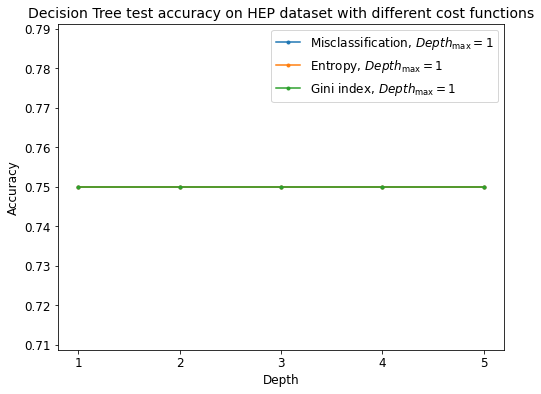

In [ ]:
ax = plt.figure(figsize=(8,6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticks(range(1,6))

ax.plot(depths,accs_mis,'.-',
        label='Misclassification, $Depth_\mathrm{max}=$'+str(depths[np.argmax(accs_mis)]))
ax.plot(depths,accs_entropy,'.-',
        label='Entropy, $Depth_\mathrm{max}=$'+str(depths[np.argmax(accs_entropy)]))
ax.plot(depths,accs_gini,'.-',
        label='Gini index, $Depth_\mathrm{max}=$'+str(depths[np.argmax(accs_gini)]))

min_cost = min(accs_gini)

ax.vlines(depths[np.argmax(accs_mis)],ymin=min_cost, ymax=max(accs_mis),
          linestyles='--',color='#1f77b4')
ax.vlines(depths[np.argmax(accs_entropy)],ymin=min_cost, ymax=max(accs_entropy),
          linestyles='--',color='#ff7f0e')
ax.vlines(depths[np.argmax(accs_gini)],ymin=min_cost, ymax=max(accs_gini),
          linestyles='--',color='#2ca02c')

plt.xlabel('Depth',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Decision Tree test accuracy on HEP dataset with different cost functions',fontsize=14)
plt.legend(fontsize=12)
plt.savefig('DTAccHEP.png')
plt.show()

missclassification original best depth: 5
missclassification original validation accuracy: 0.6114544436146377
entropy original best depth: 4
entropy original validation accuracy: 0.6424757281553397
gini original best depth: 2
gini original validation accuracy: 0.633775205377147


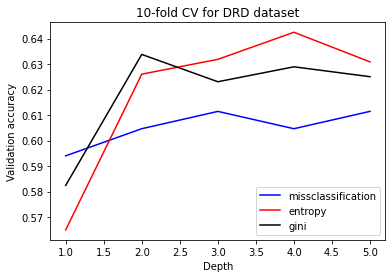

In [ ]:
# 10 fold cv
mean = []
depths = list(range(1, 6))
for k in depths:
  scr = cross_val_score(DT(max_depth=k), x_train_diab, y_train_diab, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(depths, mean, 'b', label='missclassification')

print(f'missclassification original best depth: {depths[np.argmax(mean)]}')
print(f'missclassification original validation accuracy: {np.max(mean)}')


mean = []
for k in depths:
  scr = cross_val_score(DT(max_depth=k, cost_fn=cost_entropy), x_train_diab, y_train_diab, cv=10, seed=seed)
  mean.append(np.mean(scr))

plt.plot(depths, mean, 'r', label='entropy')

print(f'entropy original best depth: {depths[np.argmax(mean)]}')
print(f'entropy original validation accuracy: {np.max(mean)}')



mean = []
for k in depths:
  scr = cross_val_score(DT(max_depth=k, cost_fn=cost_gini_index), x_train_diab_norm, y_train_diab_norm, cv=10, seed=seed)
  mean.append(np.mean(scr))
plt.plot(depths, mean, 'k', label='gini')

print(f'gini original best depth: {depths[np.argmax(mean)]}')
print(f'gini original validation accuracy: {np.max(mean)}')


plt.title('10-fold CV for DRD dataset')
plt.xlabel('Depth')
plt.ylabel('Validation accuracy')
plt.legend()
plt.savefig('DT10foldDRD.png')
plt.show()

In [ ]:
y_probs_diab = dt.fit(x_train_diab, y_train_diab, max_depth=3).predict(x_test_diab)
y_pred_diab = np.argmax(y_probs_diab,axis=-1)

acc_diab = evaluate_acc(y_test_diab, y_pred_diab)
acc_diab

(0.5043478260869565, 0.5945945945945946, 0.34375, 0.4356435643564357)

In [ ]:
depths = range(1,6)
accs_mis = []
accs_entropy = []
accs_gini = []

for depth in depths:
  tmp1 = dt.fit(x_train_diab, y_train_diab, depth, cost_fn=cost_misclassification).predict(x_test_diab)
  tmp2 = dt.fit(x_train_diab, y_train_diab, depth, cost_fn=cost_entropy).predict(x_test_diab)
  tmp3 = dt.fit(x_train_diab, y_train_diab, depth, cost_fn=cost_gini_index).predict(x_test_diab)

  tmp4 = np.argmax(tmp1,axis=-1)
  tmp5 = np.argmax(tmp2,axis=-1)
  tmp6 = np.argmax(tmp3,axis=-1)

  accs_mis.append(evaluate_acc(y_test_diab, tmp4)[0])
  accs_entropy.append(evaluate_acc(y_test_diab, tmp5)[0])
  accs_gini.append(evaluate_acc(y_test_diab, tmp6)[0])

entropy d=4 0.6


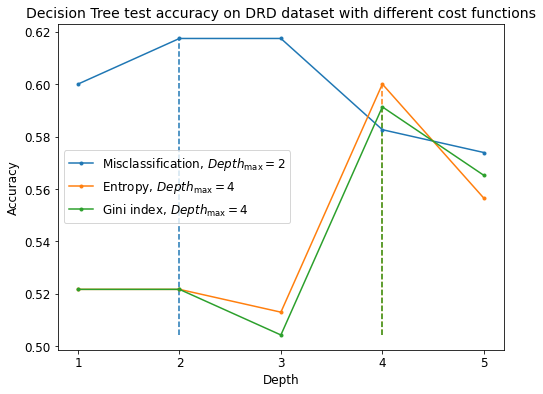

In [ ]:
ax = plt.figure(figsize=(8,6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_ticks(range(1,6))

print(f'entropy d=4 {accs_entropy[3]}')

ax.plot(depths,accs_mis,'.-',
        label='Misclassification, $Depth_\mathrm{max}=$'+str(depths[np.argmax(accs_mis)]))
ax.plot(depths,accs_entropy,'.-',
        label='Entropy, $Depth_\mathrm{max}=$'+str(depths[np.argmax(accs_entropy)]))
ax.plot(depths,accs_gini,'.-',
        label='Gini index, $Depth_\mathrm{max}=$'+str(depths[np.argmax(accs_gini)]))

min_cost = min(accs_gini)

ax.vlines(depths[np.argmax(accs_mis)],ymin=min_cost, ymax=max(accs_mis),
          linestyles='--',color='#1f77b4')
ax.vlines(depths[np.argmax(accs_entropy)],ymin=min_cost, ymax=max(accs_entropy),
          linestyles='--',color='#ff7f0e')
ax.vlines(depths[np.argmax(accs_gini)],ymin=min_cost, ymax=max(accs_gini),
          linestyles='--',color='#2ca02c')

plt.xlabel('Depth',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Decision Tree test accuracy on DRD dataset with different cost functions',fontsize=14)
plt.legend(fontsize=12)
plt.savefig('DTAccHEP.png')
plt.show()

###Decision Boundary

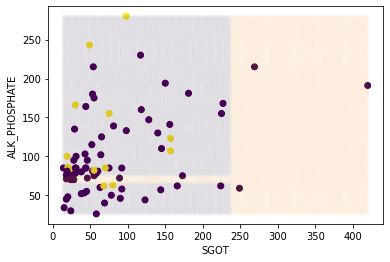

In [ ]:
#features: SGOT index=15, ALK_PHOSPHATE index=14
f1 = 14
f1name = 'ALK_PHOSPHATE'
f2 = 15
f2name = 'SGOT'

x0v = np.linspace(np.min(x_hep[:,f1]), np.max(x_hep[:,f1]), 200)
x1v = np.linspace(np.min(x_hep[:,f2]), np.max(x_hep[:,f2]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DT()

y_train_prob = np.zeros((y_hep.shape[0], 2))
y_train_prob[np.arange(y_hep.shape[0]), y_hep] = 1

y_prob_all = model.fit(x_hep[:,[f2,f1]], y_hep,max_depth=4).predict(x_all)

y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_hep[:,f2], x_hep[:,f1], c=y_train_prob[:,0], marker='o', alpha=1)
plt.scatter(x_all[:,1], x_all[:,0], c=y_pred_all[:,0], marker='.', alpha=0.01)

plt.xlabel(f2name)
plt.ylabel(f1name)
plt.savefig('DTBoundHEP.png')
plt.show()

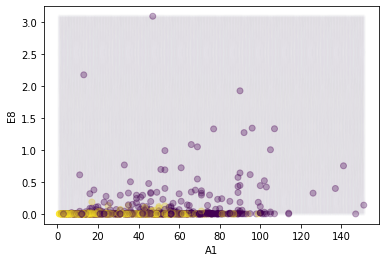

In [ ]:
f1 = -4
f1name = 'E8'
f2 = 1
f2name = 'A1'

x0v = np.linspace(np.min(x_diab[:,f1]), np.max(x_diab[:,f1]), 200)
x1v = np.linspace(np.min(x_diab[:,f2]), np.max(x_diab[:,f2]), 200)

x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DT()

y_train_prob = np.zeros((y_diab.shape[0], 2))
y_train_prob[np.arange(y_diab.shape[0]), y_diab] = 1

y_prob_all = model.fit(x_diab[:,[f2,f1]], y_diab,max_depth=4, cost_fn=cost_entropy).predict(x_all)

y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_diab[:,f2], x_diab[:,f1], c=y_train_prob[:,0], marker='o', alpha=.3)
plt.scatter(x_all[:,1], x_all[:,0], c=y_pred_all[:,0], marker='.', alpha=0.01)

plt.xlabel(f2name)
plt.ylabel(f1name)
plt.savefig('DTBoundDRD.png')
plt.show()